# 1. Import packages

In [35]:
import os
import pymysql
import pandas as pd
import sys

# Import package numpy for numeric computing
import numpy as np
import seaborn as sns
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# Import package matplotlib for visualisation/plotting
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
#For showing plots directly in the notebook run the command below
%matplotlib inline

# 2. Connect to Amazon RDS

In [2]:
# Declare and initialize database connection credentials
host = 'dbbikes.cw9hkqmrhrqy.eu-west-1.rds.amazonaws.com'
user = 'root'
password = 'hanpeisong'
db = 'dbbikes'

# Attempt connection to database
# Print a statement on the screen to check whether the connection is working
try:
    con = pymysql.connect(host = host, user = user, password = password, db = db, use_unicode = True, charset = 'utf8')
    print('Connect to Database successfully.')
except Exception as e:
        sys.exit(e)

Connect to Database successfully.


# 3. Get Data

In [3]:
# Create dataframe and store data running SQL query
df_bike = pd.read_sql_query("select * from dbbikes.bike", con)

# Examine dataframe object, show first 10 rows
df_bike.head(10)

,id,station_id,status,bike_stands,available_bike_stands,available_bikes,last_update
0,1,42,OPEN,30,26,4,2020-02-27 14:05:02
1,2,30,OPEN,20,19,1,2020-02-27 14:08:49
2,3,54,OPEN,33,17,16,2020-02-27 14:08:41
3,4,108,OPEN,40,39,1,2020-02-27 14:06:33
4,5,56,OPEN,40,2,38,2020-02-27 14:09:31
5,6,6,OPEN,20,12,8,2020-02-27 14:01:55
6,7,18,OPEN,30,23,7,2020-02-27 14:09:39
7,8,32,OPEN,30,20,10,2020-02-27 14:09:10
8,9,52,OPEN,32,18,14,2020-02-27 14:02:05
9,10,48,OPEN,40,13,27,2020-02-27 14:08:43


In [4]:
# Create dataframe and store data running SQL query
df_weather = pd.read_sql_query("select * from dbbikes.weather", con)

# Examine dataframe object, show first 10 rows
df_weather.head(10)

,id,coord_lon,coord_lat,weather_id,weather_main,weather_description,weather_icon,base,main_temp,main_feels_like,...,sys_type,sys_id,sys_message,sys_country,sys_sunrise,sys_sunset,timezone,city_id,name,cod
0,2,-6.27,53.34,803,Clouds,broken clouds,04n,stations,277.51,273.19,...,1,1565,None,IE,2020-02-28 07:16:38,2020-02-28 17:59:11,0,2964574,Dublin,200
1,3,-6.27,53.34,803,Clouds,broken clouds,04n,stations,277.51,273.19,...,1,1565,None,IE,2020-02-28 07:16:38,2020-02-28 17:59:11,0,2964574,Dublin,200
2,4,-6.27,53.34,803,Clouds,broken clouds,04n,stations,277.51,273.19,...,1,1565,None,IE,2020-02-28 07:16:38,2020-02-28 17:59:11,0,2964574,Dublin,200
3,5,-6.27,53.34,803,Clouds,broken clouds,04n,stations,277.51,273.19,...,1,1565,None,IE,2020-02-28 07:16:38,2020-02-28 17:59:11,0,2964574,Dublin,200
4,6,-6.27,53.34,803,Clouds,broken clouds,04n,stations,277.58,273.27,...,1,1565,None,IE,2020-02-28 07:16:38,2020-02-28 17:59:11,0,2964574,Dublin,200
5,7,-6.27,53.34,803,Clouds,broken clouds,04n,stations,277.58,273.27,...,1,1565,None,IE,2020-02-28 07:16:38,2020-02-28 17:59:11,0,2964574,Dublin,200
6,8,-6.27,53.34,803,Clouds,broken clouds,04n,stations,277.58,273.27,...,1,1565,None,IE,2020-02-28 07:16:38,2020-02-28 17:59:11,0,2964574,Dublin,200
7,9,-6.27,53.34,803,Clouds,broken clouds,04n,stations,277.67,273.24,...,1,1565,None,IE,2020-02-28 07:16:38,2020-02-28 17:59:11,0,2964574,Dublin,200
8,10,-6.27,53.34,500,Rain,light rain,10d,stations,279.58,272.44,...,1,1565,None,IE,2020-02-28 07:16:38,2020-02-28 17:59:11,0,2964574,Dublin,200
9,11,-6.27,53.34,500,Rain,light rain,10d,stations,279.58,272.44,...,1,1565,None,IE,2020-02-28 07:16:38,2020-02-28 17:59:11,0,2964574,Dublin,200


# 3. Prepare Data

## 3.1. Remove the repetitive data

In [5]:
# Bikes data
df_bike['last_update'].describe().T
df_bike.drop_duplicates(subset=['last_update'], keep='first', inplace=True)
df_bike['last_update'].describe().T
# Weather data
df_weather['dt'].describe().T
df_weather.drop_duplicates(subset=['dt'], keep='first', inplace=True)
df_weather['dt'].describe().T
df_bike.shape

(36004, 7)

## 3.2. Merge the bikes and weather dataframes

In [6]:
df_bike.rename(columns={'last_update':'dt'}, inplace=True)
df_bike['dt_hour'] = df_bike['dt'].dt.hour
df_bike['dt_min'] = df_bike['dt'].dt.minute
df_bike['dt_date'] = df_bike['dt'].dt.date
# The day of the week with Monday=0, Sunday=6.
df_bike['dt_dayofweek'] = df_bike['dt'].dt.dayofweek
df_weather['dt_hour'] = df_weather['dt'].dt.hour
df_weather['dt_min'] = df_weather['dt'].dt.minute
df_weather['dt_date'] = df_weather['dt'].dt.date

In [7]:
# Merge dataframes
df_merged = pd.merge(df_bike, df_weather, on = ['dt_min', 'dt_date', 'dt_hour'], how = 'inner')
# Show first 2 scraps (oldest) for stations (113*2=226)
df_merged.dtypes

id_x                              int64
station_id                        int64
status                           object
bike_stands                       int64
available_bike_stands             int64
available_bikes                   int64
dt_x                     datetime64[ns]
dt_hour                           int64
dt_min                            int64
dt_date                          object
dt_dayofweek                      int64
id_y                              int64
coord_lon                       float64
coord_lat                       float64
weather_id                        int64
weather_main                     object
weather_description              object
weather_icon                     object
base                             object
main_temp                       float64
main_feels_like                 float64
main_temp_min                   float64
main_temp_max                   float64
main_pressure                     int64
main_humidity                     int64


In [8]:
# Select columns containing categorical data
categorical_columns = df_merged[['weather_main']].columns
# Select columns containing continuous data
continuous_columns = df_merged[['station_id', 'available_bike_stands', 'available_bikes', 'dt_hour', 'dt_min', 'dt_dayofweek', 
                         'main_temp', 'main_feels_like', 'visibility', 'wind_speed', 'wind_deg']].columns
# Print table
df_merged[continuous_columns].describe().T

,count,mean,std,min,25%,50%,75%,max
station_id,2231.0,59.423577,33.444893,2.00,31.00,58.00,89.00,117.00
available_bike_stands,2231.0,19.514567,11.195316,0.00,11.00,20.00,28.00,40.00
available_bikes,2231.0,12.338861,10.019887,0.00,4.00,11.00,19.00,40.00
dt_hour,2231.0,12.164948,5.534292,0.00,9.00,12.00,16.00,23.00
dt_min,2231.0,27.845809,18.072239,0.00,14.00,27.00,44.00,59.00
dt_dayofweek,2231.0,4.476468,1.736255,0.00,3.00,5.00,6.00,6.00
main_temp,2231.0,279.141878,2.863787,274.21,276.77,278.46,280.77,286.20
main_feels_like,2231.0,272.927665,4.209239,265.76,269.28,272.44,276.13,282.17
visibility,2231.0,9894.217840,507.802533,6000.00,10000.00,10000.00,10000.00,10000.00
wind_speed,2231.0,6.576257,2.403755,0.50,5.10,6.20,7.70,11.80


In [9]:
# Print table with descriptive statistics for all the categorical features
df_merged[categorical_columns].describe().T

,count,unique,top,freq
weather_main,2231,4,Clouds,1657


## 3.3. Plot histograms for all the continuous features.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000111B8C6BA48>,
      dtype=object)

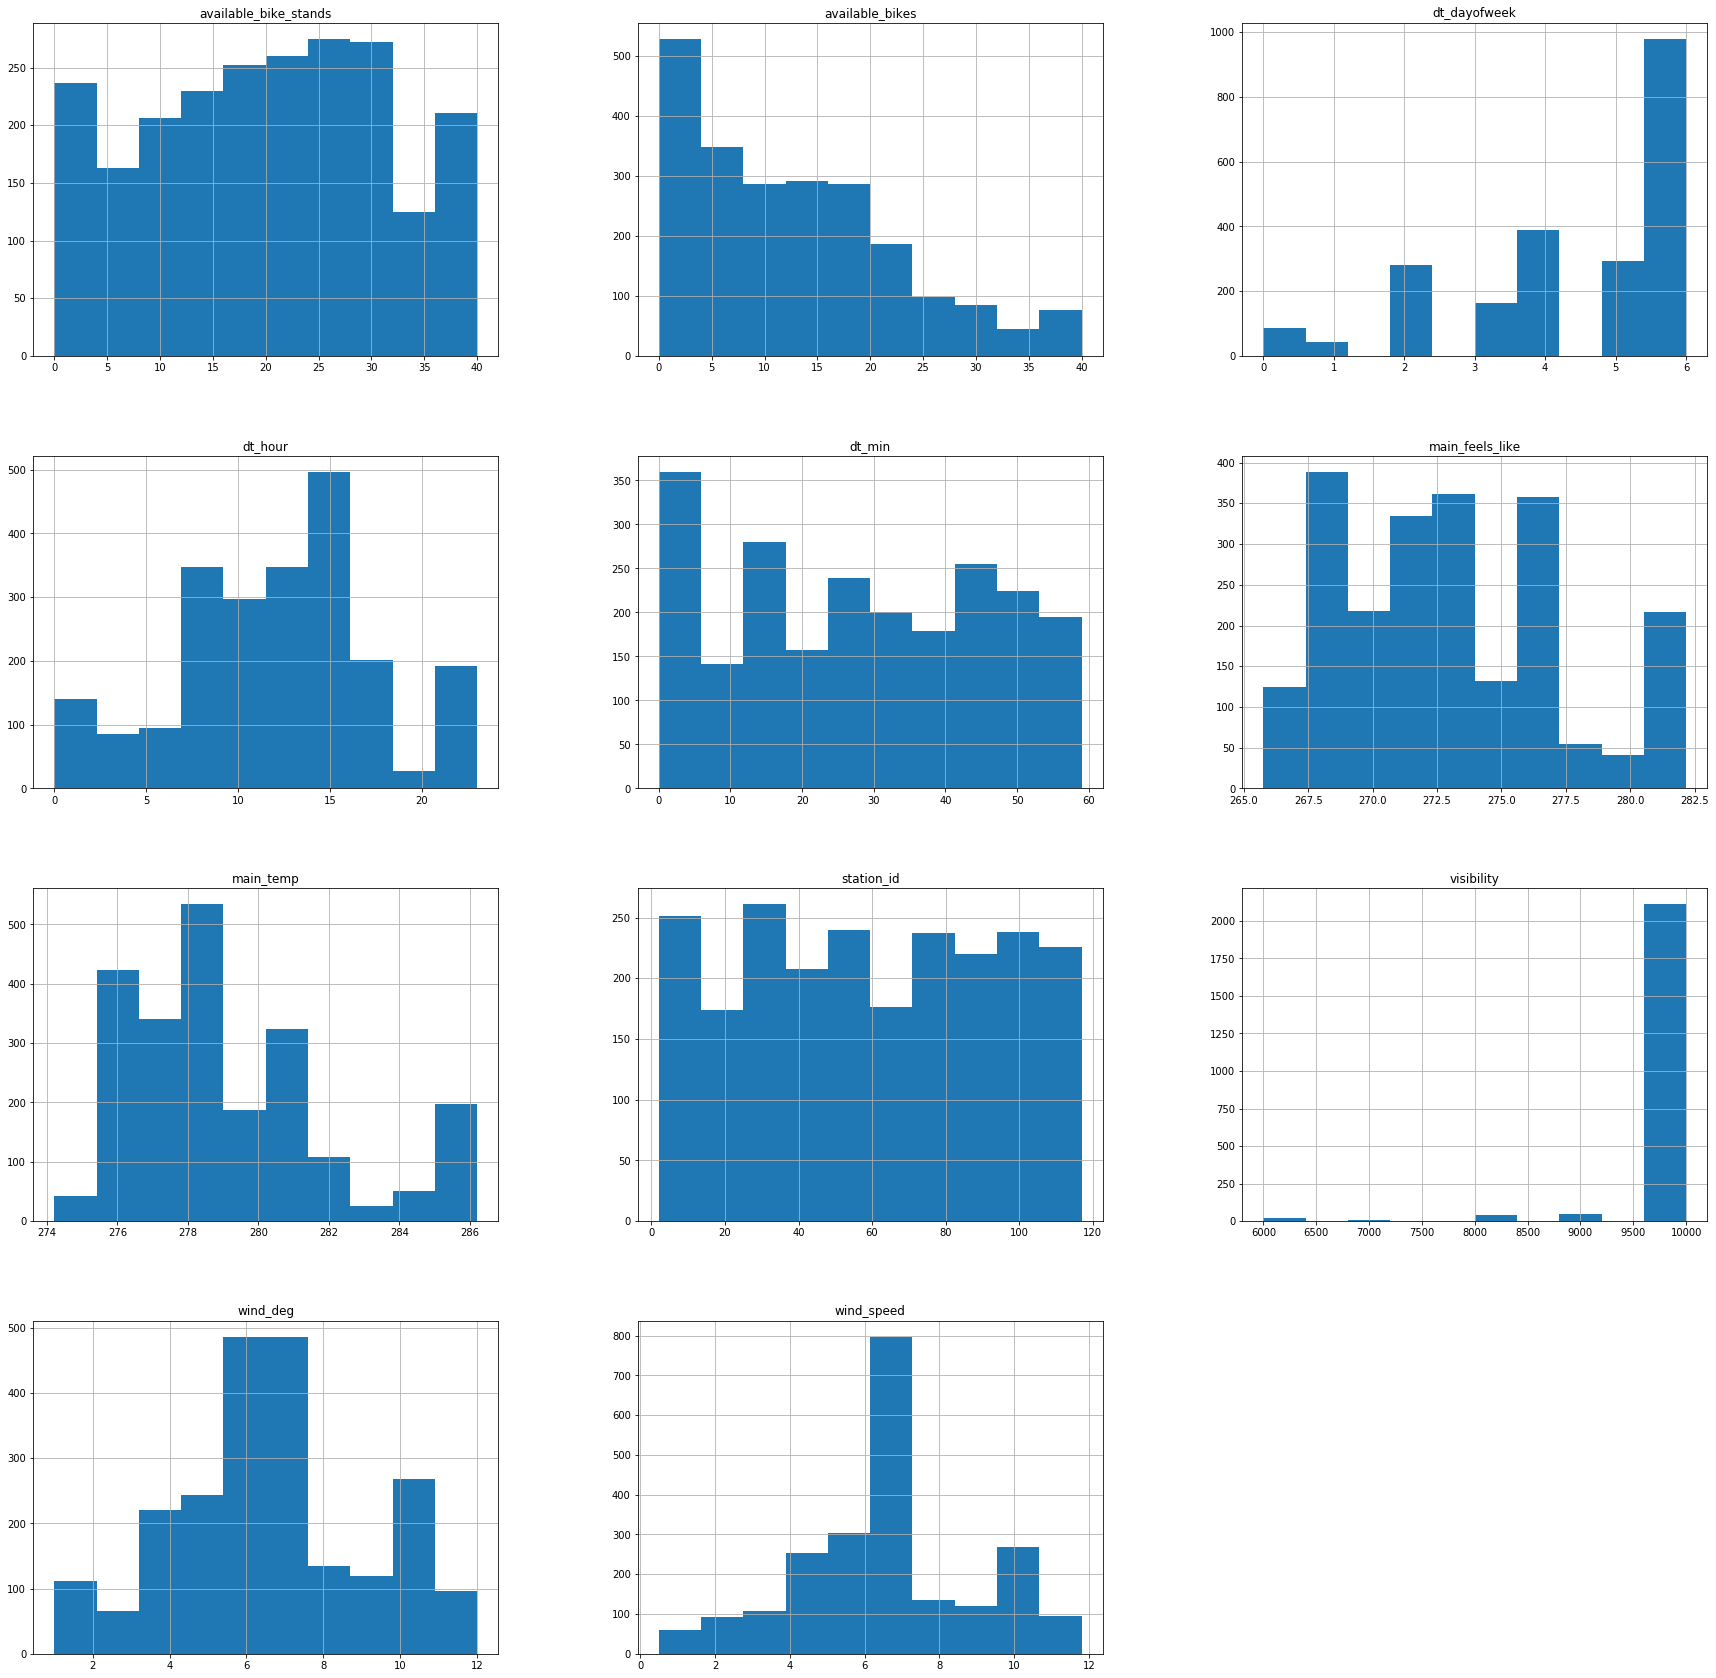

In [10]:
# Plot a histogram of the continuous features (and save in a png file)
df_merged[continuous_columns].hist(figsize=(30,30))

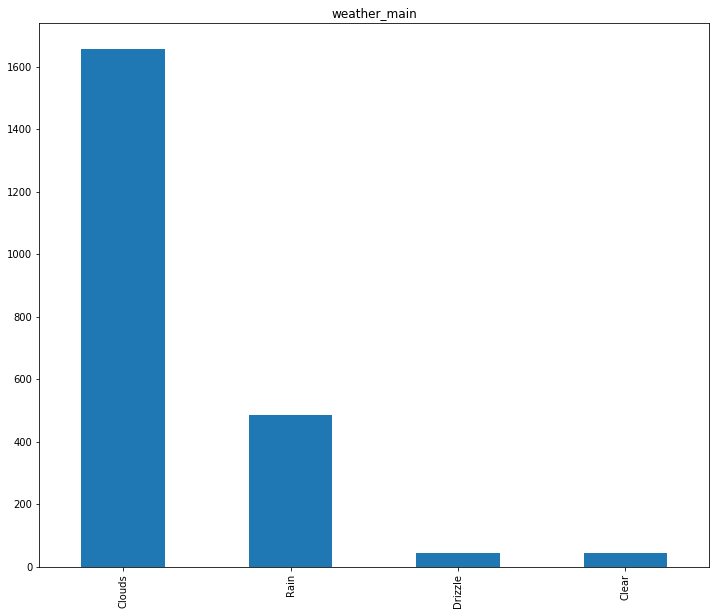

In [11]:
for column in categorical_columns:
    f = df_merged[column].value_counts().plot(kind='bar', title=column, figsize=(12,10))
    plt.show()

## 3.4. Correlations for the numeric features

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5]),
 <a list of 11 Text xticklabel objects>)

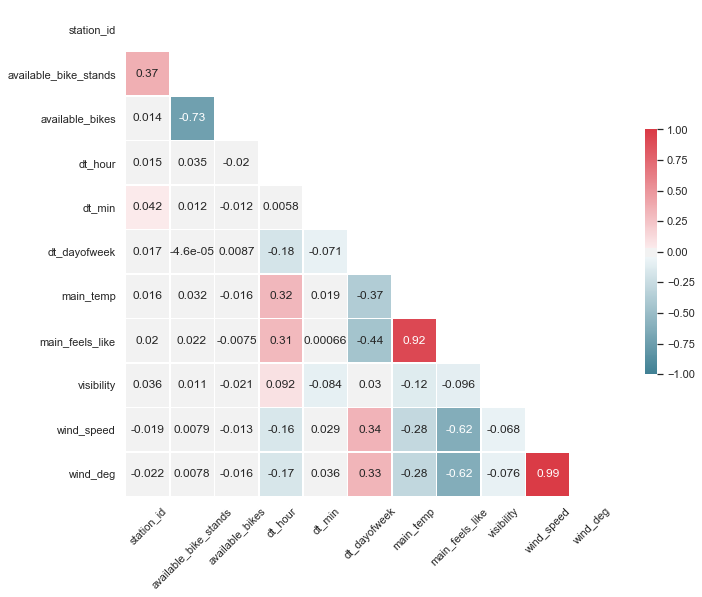

In [12]:
# Correlation matrix using code found on https://stanford.edu/~mwaskom/software/seaborn/examples/many_pairwise_correlations.html
sns.set(style="white")

# Calculate correlation of all pairs of continuous features
corr = df_merged[continuous_columns].corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom colormap - blue and red
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, annot=True, mask=mask, cmap=cmap, vmax=1, vmin=-1,
            square=True, xticklabels=True, yticklabels=True,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)
plt.yticks(rotation = 0)
plt.xticks(rotation = 45)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

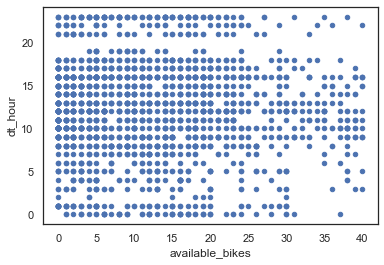

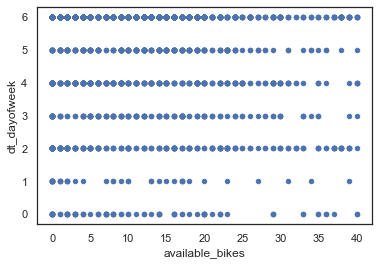

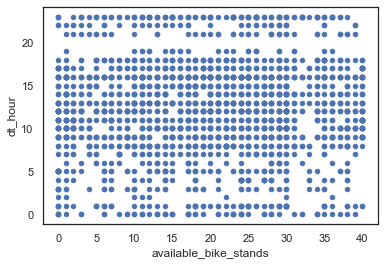

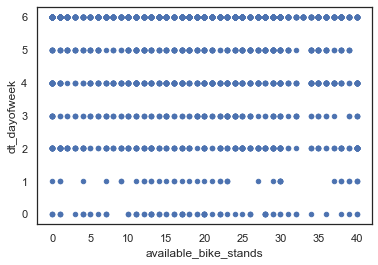

In [13]:
df_merged.plot(kind='scatter', x='available_bikes', y='dt_hour')
df_merged.plot(kind='scatter', x='available_bikes', y='dt_dayofweek')
df_merged.plot(kind='scatter', x='available_bike_stands', y='dt_hour')
df_merged.plot(kind='scatter', x='available_bike_stands', y='dt_dayofweek')

## 3.5. Continuous-categorical feature plots

<Figure size 432x288 with 0 Axes>

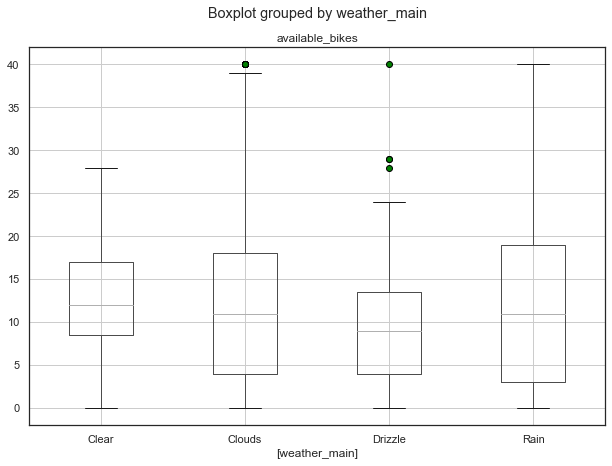

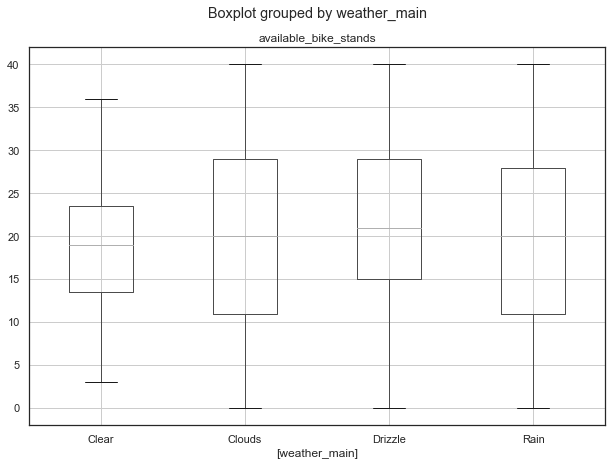

In [14]:
plt.figure()
flierprops = dict(marker='o', markerfacecolor='green', markersize=6,
                  linestyle='none')
df_merged.boxplot(column=['available_bikes'], by=['weather_main'], flierprops=flierprops, figsize=(10,7))
df_merged.boxplot(column=['available_bike_stands'], by=['weather_main'], flierprops=flierprops, figsize=(10,7))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000111B9E83148>]],
      dtype=object)

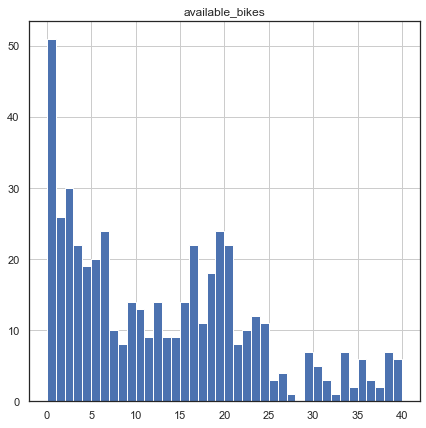

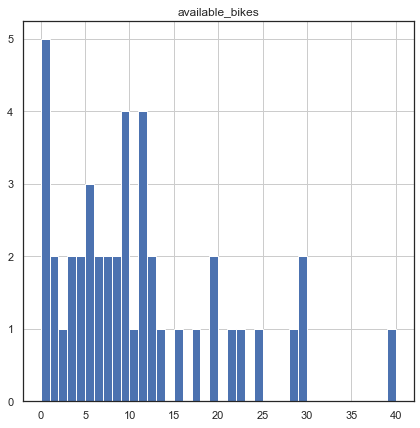

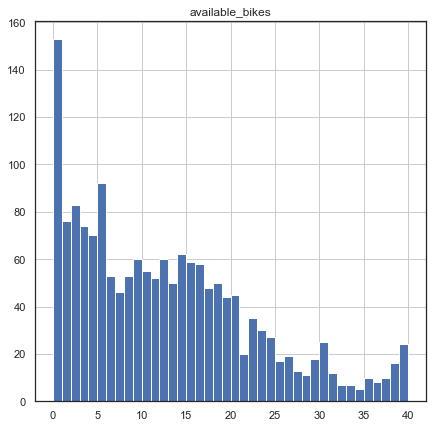

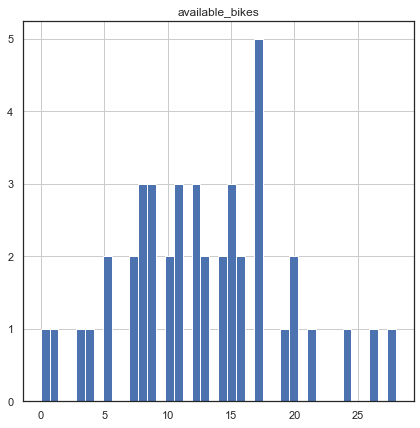

In [15]:
df_merged[df_merged['weather_main'] == 'Rain'][['available_bikes']].hist(figsize=(7,7), bins=40)
df_merged[df_merged['weather_main'] == 'Drizzle'][['available_bikes']].hist(figsize=(7,7), bins=40) 
df_merged[df_merged['weather_main'] == 'Clouds'][['available_bikes']].hist(figsize=(7,7), bins=40) 
df_merged[df_merged['weather_main'] == 'Clear'][['available_bikes']].hist(figsize=(7,7), bins=40)

In [26]:
df_station_42 = df_bike[df_bike['station_id']==42]
#df_bike['station_id'] == 42
df_station_42.head()

,id,station_id,status,bike_stands,available_bike_stands,available_bikes,dt,dt_hour,dt_min,dt_date,dt_dayofweek
0,1,42,OPEN,30,26,4,2020-02-27 14:05:02,14,5,2020-02-27,3
110,331,42,OPEN,30,1,29,2020-02-28 01:22:54,1,22,2020-02-28,4
330,551,42,OPEN,30,1,29,2020-02-28 01:33:03,1,33,2020-02-28,4
550,771,42,OPEN,30,1,29,2020-02-28 01:43:11,1,43,2020-02-28,4
770,991,42,OPEN,30,1,29,2020-02-28 01:53:19,1,53,2020-02-28,4


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

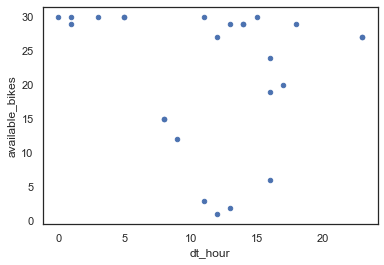

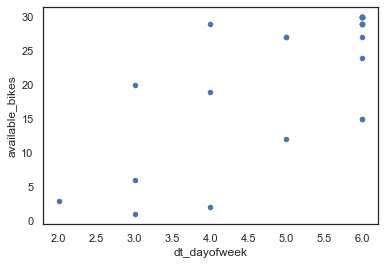

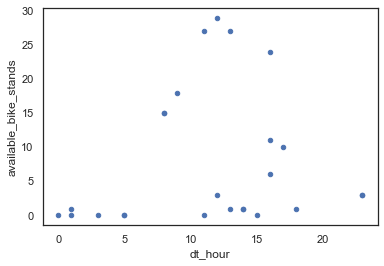

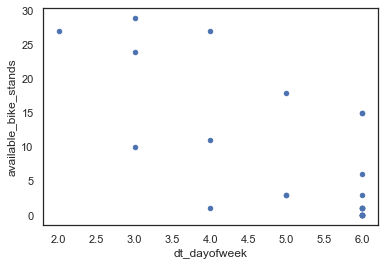

In [25]:
df_station_42.plot(kind='scatter', x='dt_hour', y='available_bikes')
df_station_42.plot(kind='scatter', x='dt_dayofweek', y='available_bikes')
df_station_42.plot(kind='scatter', x='dt_hour', y='available_bike_stands')
df_station_42.plot(kind='scatter', x='dt_dayofweek', y='available_bike_stands')

In [29]:
df_station_42 = df_merged[df_merged['station_id']==42]
#df_bike['station_id'] == 42
df_station_42.head()

,id_x,station_id,status,bike_stands,available_bike_stands,available_bikes,dt_x,dt_hour,dt_min,dt_date,...,sys_type,sys_id,sys_message,sys_country,sys_sunrise,sys_sunset,timezone,city_id,name,cod
0,331,42,OPEN,30,1,29,2020-02-28 01:22:54,1,22,2020-02-28,...,1,1565,None,IE,2020-02-28 07:16:38,2020-02-28 17:59:11,0,2964574,Dublin,200
166,4291,42,OPEN,30,27,2,2020-02-28 13:51:36,13,51,2020-02-28,...,1,1565,None,IE,2020-02-28 07:16:38,2020-02-28 17:59:11,0,2964574,Dublin,200
235,6711,42,OPEN,30,11,19,2020-02-28 16:51:43,16,51,2020-02-28,...,1,1565,None,IE,2020-02-28 07:16:38,2020-02-28 17:59:11,0,2964574,Dublin,200
439,11881,42,OPEN,30,3,27,2020-02-29 23:43:13,23,43,2020-02-29,...,1,1565,None,IE,2020-02-29 07:14:21,2020-02-29 18:01:06,0,2964574,Dublin,200
453,12101,42,OPEN,30,3,27,2020-02-29 23:53:21,23,53,2020-02-29,...,1,1565,None,IE,2020-02-29 07:14:21,2020-02-29 18:01:06,0,2964574,Dublin,200


<Figure size 432x288 with 0 Axes>

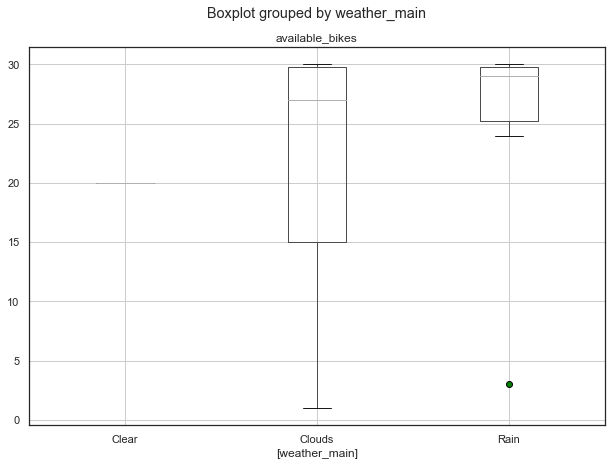

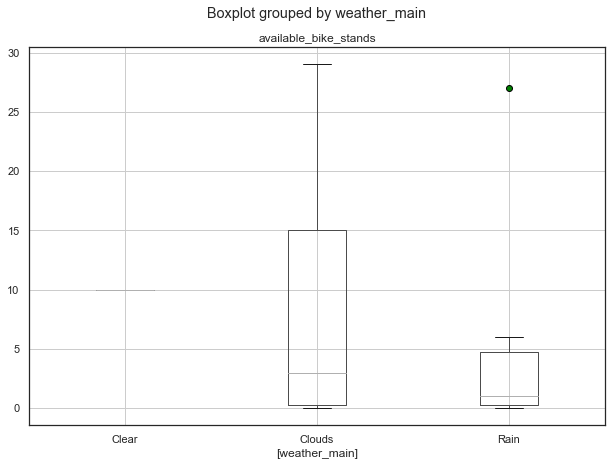

In [30]:
plt.figure()
flierprops = dict(marker='o', markerfacecolor='green', markersize=6,
                  linestyle='none')
df_station_42.boxplot(column=['available_bikes'], by=['weather_main'], flierprops=flierprops, figsize=(10,7))
df_station_42.boxplot(column=['available_bike_stands'], by=['weather_main'], flierprops=flierprops, figsize=(10,7))

## 3.6. Dummy coding
We need to incorporate the weather feature in our model, but it is not usable as it is a categorical form. So we transform them in a series of dummy variables. The process is known as "dummy coding".

In [39]:
data = pd.DataFrame(df_merged['weather_main'])
dummy = pd.get_dummies(data)
df_merged = pd.concat([df_merged, dummy],axis=1)
df_merged.head()

,id_x,station_id,status,bike_stands,available_bike_stands,available_bikes,dt_x,dt_hour,dt_min,dt_date,...,sys_sunrise,sys_sunset,timezone,city_id,name,cod,weather_main_Clear,weather_main_Clouds,weather_main_Drizzle,weather_main_Rain
0,331,42,OPEN,30,1,29,2020-02-28 01:22:54,1,22,2020-02-28,...,2020-02-28 07:16:38,2020-02-28 17:59:11,0,2964574,Dublin,200,0,1,0,0
1,333,54,OPEN,33,30,3,2020-02-28 01:22:39,1,22,2020-02-28,...,2020-02-28 07:16:38,2020-02-28 17:59:11,0,2964574,Dublin,200,0,1,0,0
2,342,43,OPEN,30,5,25,2020-02-28 01:22:51,1,22,2020-02-28,...,2020-02-28 07:16:38,2020-02-28 17:59:11,0,2964574,Dublin,200,0,1,0,0
3,345,98,OPEN,40,40,0,2020-02-28 01:22:55,1,22,2020-02-28,...,2020-02-28 07:16:38,2020-02-28 17:59:11,0,2964574,Dublin,200,0,1,0,0
4,352,84,OPEN,30,0,30,2020-02-28 01:22:53,1,22,2020-02-28,...,2020-02-28 07:16:38,2020-02-28 17:59:11,0,2964574,Dublin,200,0,1,0,0


# 4. ML Model

## 4.1. Model Training

In [40]:
# Select model features and store them in a new dataframe
input_data = pd.DataFrame(df_merged[['station_id', 'dt_dayofweek', 'dt_hour', 'dt_min', 'weather_main_Clear', 'weather_main_Clouds', 'weather_main_Drizzle', 'weather_main_Rain']])

# Define target variable
output_data = df_merged['available_bikes']

# Split dataset to train and test
x_train, x_test, y_train, y_test = train_test_split(input_data, output_data, test_size=0.25, random_state=42)
print("Training the model on %s rows and %s columns." % x_train.shape)

lr = LinearRegression()

# Train the model
lr.fit(x_train, y_train)

print("Testing the model on %s rows." % y_test.shape[0])

Training the model on 1673 rows and 8 columns.
Testing the model on 558 rows.


## 4.2 Model Testing

In [42]:
# Get prediction for test cases
prediction = lr.predict(x_test)

# Show the predicted test cases
print(prediction)
print(y_test)

[12.06191348 11.93007226 13.05351686 12.46760986 12.79360756 12.0981128
 12.55916447 11.60284191 12.89896891 12.63092387 12.14157615 12.34401451
 12.40535117 13.11322686 12.09991792 11.48255921 12.30737787 12.01577557
 11.35955013 12.83362819 11.58236449 11.72600522 12.29830482 13.59385274
 12.10740549 12.76325667 12.84440384 11.75842148 12.44952008 11.89303331
 11.46039045 12.40276705 11.5269246  12.02703209 12.87008355 13.41447082
 11.76373181 11.60689764 11.77056334 12.42304702 11.9915305  12.01928728
 13.05034664 12.29583372 12.41623193 11.44576237 12.30339474 12.38817708
 12.64187607 12.78601991 11.75883782 12.25468129 11.86261527 13.24374399
 11.93523176 12.20025589 12.74354141 12.52171492 12.55053432 12.45662759
 12.69267037 12.3449536  12.78241757 12.5441727  11.86892782 11.95921558
 12.86474724 11.94953961 11.61771553 11.88278118 11.37607833 12.13434498
 11.19644575 12.98487418 12.36084183 12.26689053 11.73543092 11.77938546
 12.36702756 12.2538744  12.6744186  11.13530131 12.

## 4.3. Model Evaluation

In [43]:
print("RMSE: %f" % np.sqrt(metrics.mean_squared_error(y_test, prediction)))

RMSE: 9.939153


## 4.4. Model Serialising

In [45]:
import pickle
with open('model.pkl', 'wb') as handle:
    pickle.dump(lr, handle, pickle.HIGHEST_PROTOCOL)